In [1]:
import qiskit
import qiskit_aer
from qiskit_aer import AerSimulator
import numpy as np

In [2]:
def evolve_basic(g, dt, N):
    
    circ = qiskit.QuantumCircuit(N)
    
    x_angle = - dt * g

    z_angle = - dt
    
    
    #e^B
    for i in range(int(N/2-1)):
        circ.rzz(z_angle, 2*i+1, 2*i+2) # x rotation
        
    for i in range(int(N/2)):
        circ.rzz(z_angle, 2*i, 2*i+1) # x rotation
           
    #e^A        
    for i in range(N):
        circ.rx(x_angle, i) # x rotation
    
    return circ

In [3]:
def evolve_symmetric(g, dt, N):
    
    circ = qiskit.QuantumCircuit(N)
    
    x_angle = - dt * g

    z_angle = - dt
    
    for i in range(N):
        
        circ.rx(x_angle/2, i) # x rotation
        
        
    for i in range(int(N/2-1)):
        
        circ.rzz(z_angle, 2*i+1, 2*i+2) # x rotation
        
    for i in range(int(N/2)):
        
        circ.rzz(z_angle, 2*i, 2*i+1) # x rotation
        
    for i in range(N):
        
        circ.rx(x_angle/2, i) # x rotation

    return circ

In [4]:
import exact_diagonalization
N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)

In [5]:
test = exact_diagonalization.magn_exact_diagonalization(N, g, t, array_size)

In [6]:
mt_smooth = np.zeros((array_size))
N = 10
Evolve_Basic = evolve_basic(g, dt, N)
for i in range(array_size):
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.save_statevector()
    sim = AerSimulator()
    result = sim.run(combined).result()
    psi = result.get_statevector()
    magnetization = 0
    psi.draw('latex')
    for j, amplitude in enumerate(psi):
        if amplitude == 0: 
            continue
        else:
            basis_state = f'{j:0{N}b}'  # binary representation of the basis state
            num_zeros = basis_state.count('0')
            magnetization += (2*num_zeros - N) * (np.abs(amplitude) ** 2)
    mt_smooth[i] = magnetization /10

C:\Users\joshu\AppData\Local\Temp\ipykernel_7512\4265064952.py:14: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for j, amplitude in enumerate(psi):


In [7]:
mt_smooth_1 = np.zeros((array_size))
Evolve_Basic = evolve_symmetric(g, dt, N)
for i in range(array_size):
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.save_statevector()
    sim = AerSimulator()
    result = sim.run(combined).result()
    psi = result.get_statevector()
    magnetization = 0
    psi.draw('latex')
    for j, amplitude in enumerate(psi):
        if amplitude == 0: 
            continue
        else:
            basis_state = f'{j:0{N}b}'  # binary representation of the basis state
            num_zeros = basis_state.count('0')
            magnetization += (2*num_zeros - N) * (np.abs(amplitude) ** 2)
    mt_smooth_1[i] = magnetization /10

C:\Users\joshu\AppData\Local\Temp\ipykernel_7512\3422611086.py:13: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for j, amplitude in enumerate(psi):


In [8]:
mt = np.zeros(array_size)
Evolve_Basic = evolve_basic(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.measure_all()
    sim = AerSimulator()
    shot = 20
    result = sim.run(combined, shots = shot).result().get_counts()

    total = 0

# Iterate through the dictionary items
    for binary_str, count in result.items():
        # Count the number of ones in the binary string
        num_zeros = binary_str.count('0')
        # Multiply the count of ones by the histogram count
        total += (2*num_zeros - N) * count
    mt[i] = total / shot / N

In [9]:
mt2 = np.zeros(array_size)
Evolve_Sym = evolve_symmetric(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Sym)
    combined.measure_all()
    sim = AerSimulator()
    shot = 100
    result = sim.run(combined, shots = shot).result().get_counts()

    total = 0

# Iterate through the dictionary items
    for binary_str, count in result.items():
        # Count the number of ones in the binary string
        num_zeros = binary_str.count('0')
        # Multiply the count of ones by the histogram count
        total += (2*num_zeros - N) * count
    mt2[i] = total / shot / N

In [10]:
N = [6, 8, 10, 12]
lambd_smooth = np.zeros((np.size(N),array_size, 3))
q = 0
g = 2
for x in N:
    Evolve_Basic = evolve_basic(g, dt, x)
    for i in range(array_size):
    
        combined = qiskit.QuantumCircuit(x)
        for j in range(i):
            combined = combined.compose(Evolve_Basic)
        combined.save_statevector()
        sim = AerSimulator()
        result = sim.run(combined).result()
        psi = result.get_statevector()
        proj0 = np.abs(np.array(psi)[0])
        proj1 = np.abs(np.array(psi)[-1])

        lambd_smooth[q][i][0] = -np.log(proj0*proj0)/x
        lambd_smooth[q][i][1] = -np.log(proj1*proj1)/x
        lambd_smooth[q][i][2] = -np.log(proj0*proj0 + proj1*proj1)/x 
    q += 1

C:\Users\joshu\AppData\Local\Temp\ipykernel_7512\18993647.py:20: RuntimeWarning: divide by zero encountered in log
  lambd_smooth[q][i][1] = -np.log(proj1*proj1)/x


In [11]:
N = [6, 8, 10, 12]
lambd_smooth_sym = np.zeros((np.size(N),array_size, 3))
q = 0
g = 2
for x in N:
    Evolve_Basic = evolve_symmetric(g, dt, x)
    for i in range(array_size):
    
        combined = qiskit.QuantumCircuit(x)
        for j in range(i):
            combined = combined.compose(Evolve_Basic)
        combined.save_statevector()
        sim = AerSimulator()
        result = sim.run(combined).result()
        psi = result.get_statevector()
        proj0 = np.abs(np.array(psi)[0])
        proj1 = np.abs(np.array(psi)[-1])

        lambd_smooth_sym[q][i][0] = -np.log(proj0*proj0)/x
        lambd_smooth_sym[q][i][1] = -np.log(proj1*proj1)/x
        lambd_smooth_sym[q][i][2] = -np.log(proj0*proj0 + proj1*proj1)/x 
    q += 1

C:\Users\joshu\AppData\Local\Temp\ipykernel_7512\1290031667.py:20: RuntimeWarning: divide by zero encountered in log
  lambd_smooth_sym[q][i][1] = -np.log(proj1*proj1)/x


In [12]:
g = np.linspace(0.5, 1.5, 10)
lambd_smooth_1 = np.zeros((np.size(g),array_size, 3))
N = 10
r = 0
for x in g:
    Evolve_Basic = evolve_basic(x, dt, N)
    for i in range(array_size):
    
        combined = qiskit.QuantumCircuit(N)
        for j in range(i):
            combined = combined.compose(Evolve_Basic)
        combined.save_statevector()
        sim = AerSimulator()
        result = sim.run(combined).result()
        psi = result.get_statevector()
        proj0 = np.abs(np.array(psi)[0])
        proj1 = np.abs(np.array(psi)[-1])

        lambd_smooth_1[r][i][0] = -np.log(proj0*proj0)/N
        lambd_smooth_1[r][i][1] = -np.log(proj1*proj1)/N
        lambd_smooth_1[r][i][2] = -np.log(proj0*proj0 + proj1*proj1)/N
    r += 1

C:\Users\joshu\AppData\Local\Temp\ipykernel_7512\4293311925.py:20: RuntimeWarning: divide by zero encountered in log
  lambd_smooth_1[r][i][1] = -np.log(proj1*proj1)/N


In [13]:
g = np.linspace(0.5, 1.5, 10)
lambd_smooth_sym_1 = np.zeros((np.size(g),array_size, 3))
N = 10
r = 0
for x in g:
    Evolve_Basic = evolve_symmetric(x, dt, N)
    for i in range(array_size):
    
        combined = qiskit.QuantumCircuit(N)
        for j in range(i):
            combined = combined.compose(Evolve_Basic)
        combined.save_statevector()
        sim = AerSimulator()
        result = sim.run(combined).result()
        psi = result.get_statevector()
        proj0 = np.abs(np.array(psi)[0])
        proj1 = np.abs(np.array(psi)[-1])

        lambd_smooth_sym_1[r][i][0] = -np.log(proj0*proj0)/N
        lambd_smooth_sym_1[r][i][1] = -np.log(proj1*proj1)/N
        lambd_smooth_sym_1[r][i][2] = -np.log(proj0*proj0 + proj1*proj1)/N
    r += 1

C:\Users\joshu\AppData\Local\Temp\ipykernel_7512\4047010715.py:20: RuntimeWarning: divide by zero encountered in log
  lambd_smooth_sym_1[r][i][1] = -np.log(proj1*proj1)/N


In [14]:
N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)
lambd_ex9 = np.zeros((array_size, 3))
Evolve_Basic = evolve_basic(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.measure_all()
    sim = AerSimulator()
    shot = 1000000
    result = sim.run(combined, shots = shot).result().get_counts()
    
    proj0 = 0
    proj1 = 0
    try:
        proj0 = result['0'*N]/shot
    except KeyError:
        proj0 = 1
    try:
        proj1 = result['1'*N]/shot
    except KeyError:
        proj1 = 1
        
    lambd_ex9[i][0] = -np.log(proj0)/N
    lambd_ex9[i][1] = -np.log(proj1)/N
    lambd_ex9[i][2] = -np.log(proj0 + proj1)/N

In [55]:
N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)
lambd_ex9_20 = np.zeros((array_size, 3))
Evolve_Basic = evolve_basic(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.measure_all()
    sim = AerSimulator()
    shot = 1000
    result = sim.run(combined, shots = shot).result().get_counts()
    
    proj0 = 0
    proj1 = 0
    try:
        proj0 = result['0'*N]/shot
    except KeyError:
        proj0 = 1
    try:
        proj1 = result['1'*N]/shot
    except KeyError:
        proj1 = 1
        
    lambd_ex9_20[i][0] = -np.log(proj0)/N
    lambd_ex9_20[i][1] = -np.log(proj1)/N
    lambd_ex9_20[i][2] = -np.log(proj0 + proj1)/N

In [15]:
N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)
lambd_ex9_1 = np.zeros((array_size, 3))
Evolve_Basic = evolve_symmetric(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.measure_all()
    sim = AerSimulator()
    shot = 1000000
    result = sim.run(combined, shots = shot).result().get_counts()
    
    proj0 = 0
    proj1 = 0
    try:
        proj0 = result['0'*N]/shot
    except KeyError:
        proj0 = 1
    try:
        proj1 = result['1'*N]/shot
    except KeyError:
        proj1 = 1
        
    lambd_ex9_1[i][0] = -np.log(proj0)/N
    lambd_ex9_1[i][1] = -np.log(proj1)/N
    lambd_ex9_1[i][2] = -np.log(proj0 + proj1)/N

In [56]:
N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)
lambd_ex9_1_20 = np.zeros((array_size, 3))
Evolve_Basic = evolve_symmetric(g, dt, N)
for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
    combined.measure_all()
    sim = AerSimulator()
    shot = 1000
    result = sim.run(combined, shots = shot).result().get_counts()
    
    proj0 = 0
    proj1 = 0
    try:
        proj0 = result['0'*N]/shot
    except KeyError:
        proj0 = 1
    try:
        proj1 = result['1'*N]/shot
    except KeyError:
        proj1 = 1
        
    lambd_ex9_1_20[i][0] = -np.log(proj0)/N
    lambd_ex9_1_20[i][1] = -np.log(proj1)/N
    lambd_ex9_1_20[i][2] = -np.log(proj0 + proj1)/N

In [86]:
Evolve_Basic = evolve_basic(x, dt, N)
Evolve_Basic.draw('mpl', filename = 'evolve_basic.png')

CircuitError: 'Expected an instance of Qubit, Clbit, or AncillaQubit, but was passed 6'

In [ ]:
Evolve_Sym = evolve_symmetric(x, dt, N)
Evolve_Sym.draw('mpl', filename = 'evolve_sym.png')

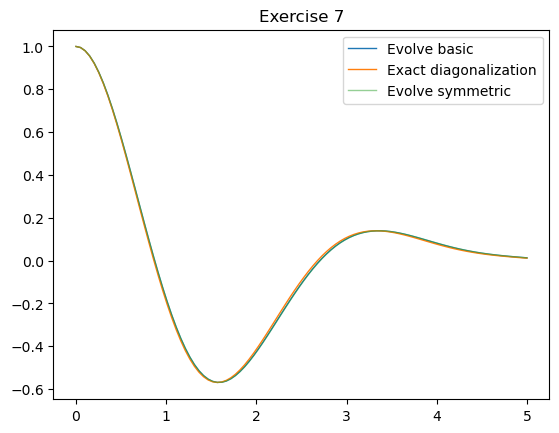

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
time = np.linspace(0, 5, array_size)
plt.plot(time, mt_smooth, label = 'Evolve basic', linewidth = 1)
plt.plot(time, test, label = 'Exact diagonalization', linewidth = 1)
plt.plot(time, mt_smooth_1, label = 'Evolve symmetric', linewidth = 1, alpha = 0.5)
plt.legend()
plt.title('Exercise 7')
plt.savefig('ex_7.png', dpi = 300)

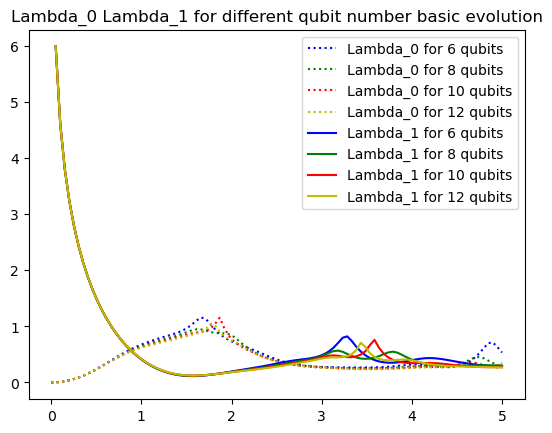

In [88]:
N = [6, 8, 10, 12]

plt.plot(time, lambd_smooth[0,:,0], 'b:', label = 'Lambda_0 for 6 qubits')
plt.plot(time, lambd_smooth[1,:,0], 'g:', label = 'Lambda_0 for 8 qubits')
plt.plot(time, lambd_smooth[2,:,0], 'r:', label = 'Lambda_0 for 10 qubits')
plt.plot(time, lambd_smooth[3,:,0], 'y:', label = 'Lambda_0 for 12 qubits')
plt.plot(time, lambd_smooth[0,:,1], 'b-', label = 'Lambda_1 for 6 qubits')
plt.plot(time, lambd_smooth[1,:,1], 'g-', label = 'Lambda_1 for 8 qubits')
plt.plot(time, lambd_smooth[2,:,1], 'r-', label = 'Lambda_1 for 10 qubits')
plt.plot(time, lambd_smooth[3,:,1], 'y-', label = 'Lambda_1 for 12 qubits')

plt.legend()
plt.title('Lambda_0 Lambda_1 for different qubit number basic evolution')
plt.savefig('lambda01_qubit_basic.png', dpi = 300)

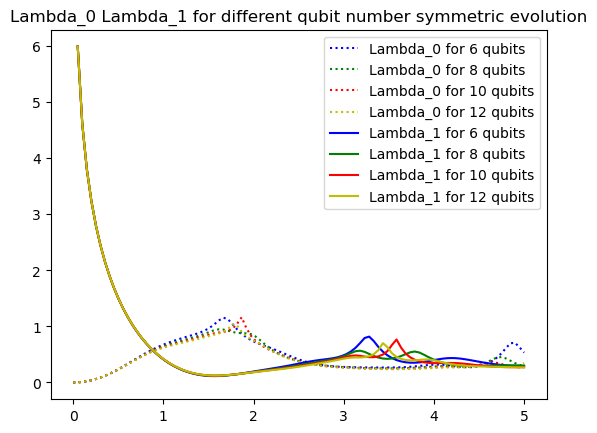

In [89]:
plt.plot(time, lambd_smooth_sym[0,:,0], 'b:', label = 'Lambda_0 for 6 qubits')
plt.plot(time, lambd_smooth_sym[1,:,0], 'g:', label = 'Lambda_0 for 8 qubits')
plt.plot(time, lambd_smooth_sym[2,:,0], 'r:', label = 'Lambda_0 for 10 qubits')
plt.plot(time, lambd_smooth_sym[3,:,0], 'y:', label = 'Lambda_0 for 12 qubits')
plt.plot(time, lambd_smooth_sym[0,:,1], 'b-', label = 'Lambda_1 for 6 qubits')
plt.plot(time, lambd_smooth_sym[1,:,1], 'g-', label = 'Lambda_1 for 8 qubits')
plt.plot(time, lambd_smooth_sym[2,:,1], 'r-', label = 'Lambda_1 for 10 qubits')
plt.plot(time, lambd_smooth_sym[3,:,1], 'y-', label = 'Lambda_1 for 12 qubits')

plt.legend()
plt.title('Lambda_0 Lambda_1 for different qubit number symmetric evolution')
plt.savefig('lambda01_qubit_sym.png', dpi = 300)

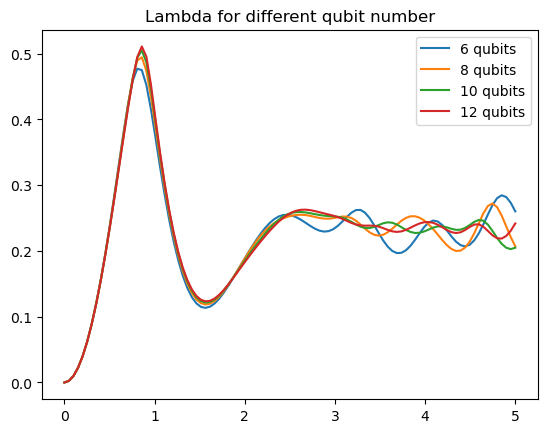

In [90]:
for i in range(4):
    plt.plot(time, lambd_smooth[i,:,2], label = f'{N[i]} qubits')
    plt.legend()
    plt.title('Lambda for different qubit number')
plt.savefig('lambda_qubit_basic.png', dpi = 300)

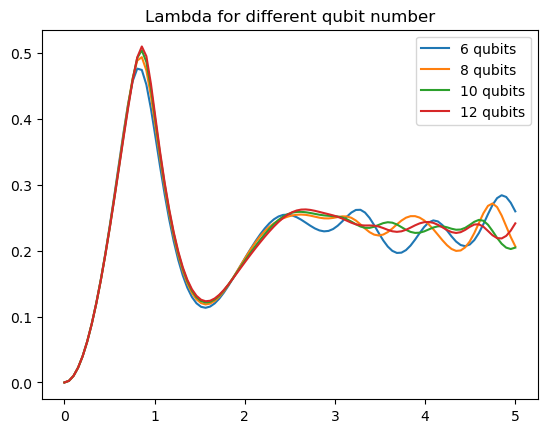

In [91]:
for i in range(4):
    plt.plot(time, lambd_smooth_sym[i,:,2], label = f'{N[i]} qubits')
    plt.legend()
    plt.title('Lambda for different qubit number')
plt.savefig('lambda_qubit_sym.png', dpi = 300)

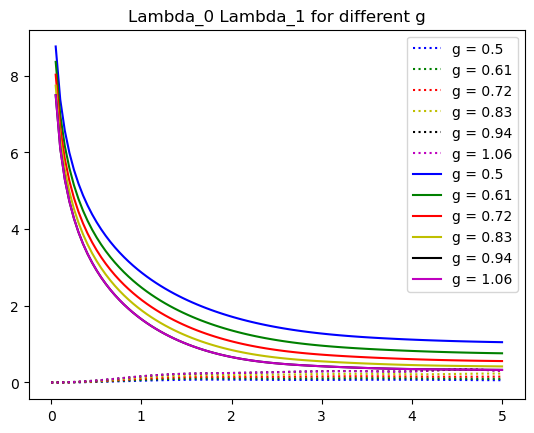

In [92]:
g = np.linspace(0.5, 1.5, 10)

plt.plot(time, lambd_smooth_1[0,:,0], 'b:', label = f'g = {round(g[0],2)}')
plt.plot(time, lambd_smooth_1[1,:,0], 'g:', label = f'g = {round(g[1],2)}')
plt.plot(time, lambd_smooth_1[2,:,0], 'r:', label = f'g = {round(g[2],2)}')
plt.plot(time, lambd_smooth_1[3,:,0], 'y:', label = f'g = {round(g[3],2)}')
plt.plot(time, lambd_smooth_1[4,:,0], 'k:', label = f'g = {round(g[4],2)}')
plt.plot(time, lambd_smooth_1[4,:,0], 'm:', label = f'g = {round(g[5],2)}')
plt.plot(time, lambd_smooth_1[0,:,1], 'b-', label = f'g = {round(g[0],2)}')
plt.plot(time, lambd_smooth_1[1,:,1], 'g-', label = f'g = {round(g[1],2)}')
plt.plot(time, lambd_smooth_1[2,:,1], 'r-', label = f'g = {round(g[2],2)}')
plt.plot(time, lambd_smooth_1[3,:,1], 'y-', label = f'g = {round(g[3],2)}')
plt.plot(time, lambd_smooth_1[4,:,1], 'k-', label = f'g = {round(g[4],2)}')
plt.plot(time, lambd_smooth_1[4,:,1], 'm-', label = f'g = {round(g[5],2)}')

plt.legend()
plt.title('Lambda_0 Lambda_1 for different g')
plt.savefig('lambda01_g_basic.png', dpi = 300)

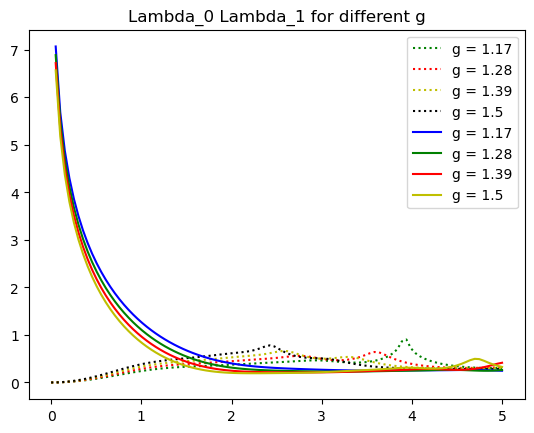

In [93]:
g = np.linspace(0.5, 1.5, 10)


plt.plot(time, lambd_smooth_1[6,:,0], 'g:', label = f'g = {round(g[6],2)}')
plt.plot(time, lambd_smooth_1[7,:,0], 'r:', label = f'g = {round(g[7],2)}')
plt.plot(time, lambd_smooth_1[8,:,0], 'y:', label = f'g = {round(g[8],2)}')
plt.plot(time, lambd_smooth_1[9,:,0], 'k:', label = f'g = {round(g[9],2)}')

plt.plot(time, lambd_smooth_1[6,:,1], 'b-', label = f'g = {round(g[6],2)}')
plt.plot(time, lambd_smooth_1[7,:,1], 'g-', label = f'g = {round(g[7],2)}')
plt.plot(time, lambd_smooth_1[8,:,1], 'r-', label = f'g = {round(g[8],2)}')
plt.plot(time, lambd_smooth_1[9,:,1], 'y-', label = f'g = {round(g[9],2)}')

plt.legend()
plt.title('Lambda_0 Lambda_1 for different g')
plt.savefig('lambda01_g_basic_DPQT.png', dpi = 300)

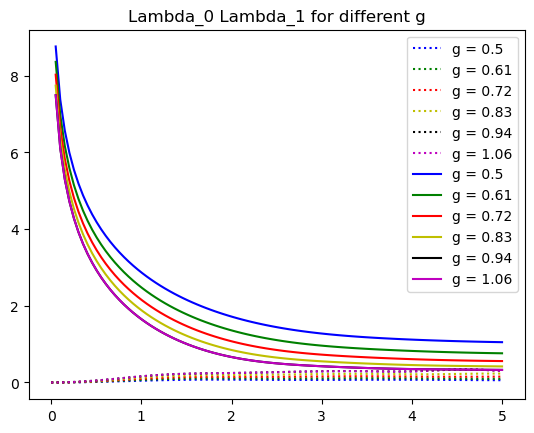

In [94]:
plt.plot(time, lambd_smooth_sym_1[0,:,0], 'b:', label = f'g = {round(g[0],2)}')
plt.plot(time, lambd_smooth_sym_1[1,:,0], 'g:', label = f'g = {round(g[1],2)}')
plt.plot(time, lambd_smooth_sym_1[2,:,0], 'r:', label = f'g = {round(g[2],2)}')
plt.plot(time, lambd_smooth_sym_1[3,:,0], 'y:', label = f'g = {round(g[3],2)}')
plt.plot(time, lambd_smooth_sym_1[4,:,0], 'k:', label = f'g = {round(g[4],2)}')
plt.plot(time, lambd_smooth_sym_1[4,:,0], 'm:', label = f'g = {round(g[5],2)}')
plt.plot(time, lambd_smooth_sym_1[0,:,1], 'b-', label = f'g = {round(g[0],2)}')
plt.plot(time, lambd_smooth_sym_1[1,:,1], 'g-', label = f'g = {round(g[1],2)}')
plt.plot(time, lambd_smooth_sym_1[2,:,1], 'r-', label = f'g = {round(g[2],2)}')
plt.plot(time, lambd_smooth_sym_1[3,:,1], 'y-', label = f'g = {round(g[3],2)}')
plt.plot(time, lambd_smooth_sym_1[4,:,1], 'k-', label = f'g = {round(g[4],2)}')
plt.plot(time, lambd_smooth_sym_1[4,:,1], 'm-', label = f'g = {round(g[5],2)}')

plt.legend()
plt.title('Lambda_0 Lambda_1 for different g')
plt.savefig('lambda01_g_sym.png', dpi = 300)

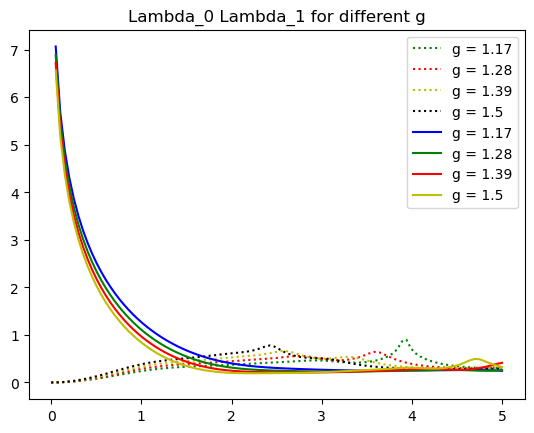

In [95]:
plt.plot(time, lambd_smooth_sym_1[6,:,0], 'g:', label = f'g = {round(g[6],2)}')
plt.plot(time, lambd_smooth_sym_1[7,:,0], 'r:', label = f'g = {round(g[7],2)}')
plt.plot(time, lambd_smooth_sym_1[8,:,0], 'y:', label = f'g = {round(g[8],2)}')
plt.plot(time, lambd_smooth_sym_1[9,:,0], 'k:', label = f'g = {round(g[9],2)}')

plt.plot(time, lambd_smooth_sym_1[6,:,1], 'b-', label = f'g = {round(g[6],2)}')
plt.plot(time, lambd_smooth_sym_1[7,:,1], 'g-', label = f'g = {round(g[7],2)}')
plt.plot(time, lambd_smooth_sym_1[8,:,1], 'r-', label = f'g = {round(g[8],2)}')
plt.plot(time, lambd_smooth_sym_1[9,:,1], 'y-', label = f'g = {round(g[9],2)}')

plt.legend()
plt.title('Lambda_0 Lambda_1 for different g')
plt.savefig('lambda01_g_sym_DPQT.png', dpi = 300)

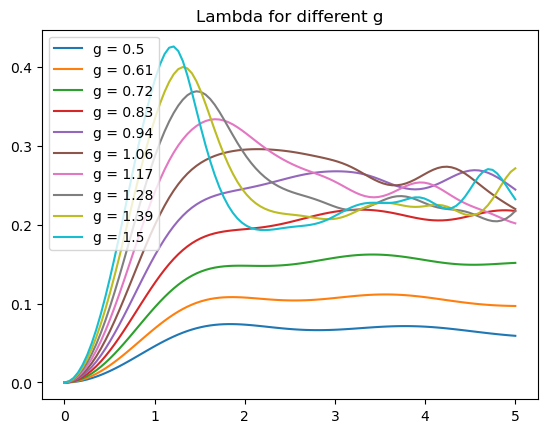

In [96]:
for i in range(10):
    plt.plot(time, lambd_smooth_1[i,:,2], label = f'g = {round(g[i],2)}')
    plt.legend()
    plt.title('Lambda for different g')
plt.savefig('lambda_g_basic.png', dpi = 300)

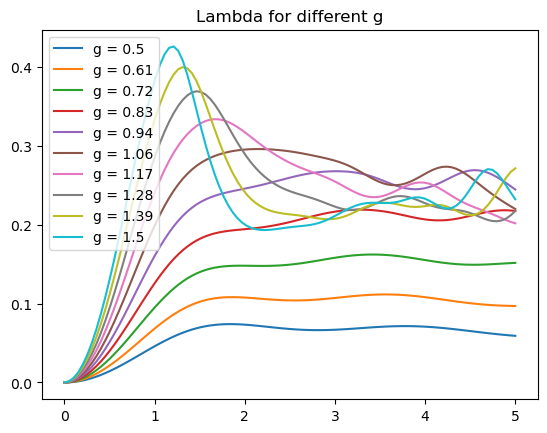

In [97]:
for i in range(10):
    plt.plot(time, lambd_smooth_sym_1[i,:,2], label = f'g = {round(g[i],2)}')
    plt.legend()
    plt.title('Lambda for different g')
plt.savefig('lambda_g_sym.png', dpi = 300)

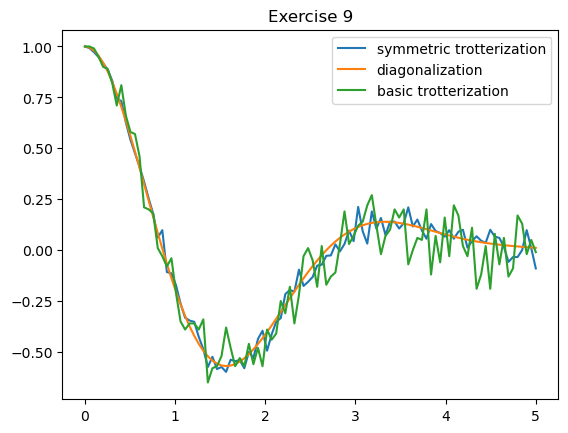

In [98]:
plt.plot(time, mt2, label = 'symmetric trotterization')
plt.plot(time,test, label = 'diagonalization')
plt.plot(time, mt, label = 'basic trotterization')
plt.legend()
plt.title('Results with 100 measurements')
plt.title('Exercise 9')
plt.savefig('ex9.png', dpi = 300)

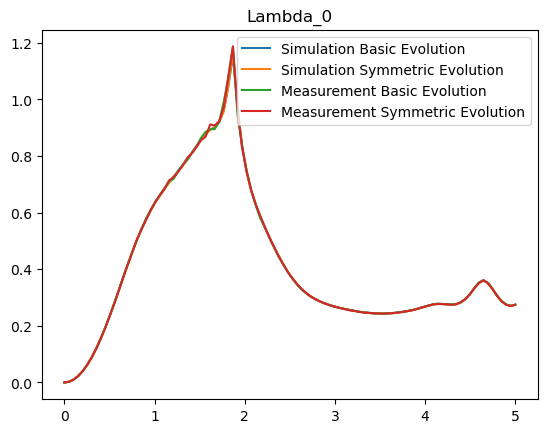

In [99]:
plt.plot(time, lambd_smooth[2,:,0], label = f'Simulation Basic Evolution')
plt.plot(time, lambd_smooth_sym[2,:,0], label = f'Simulation Symmetric Evolution')
plt.plot(time, lambd_ex9[:,0], label = f'Measurement Basic Evolution')
plt.plot(time, lambd_ex9_1[:,0], label = f'Measurement Symmetric Evolution')
plt.legend()
plt.title('Lambda_0')
plt.savefig('lambda0_ex9.png', dpi = 300)

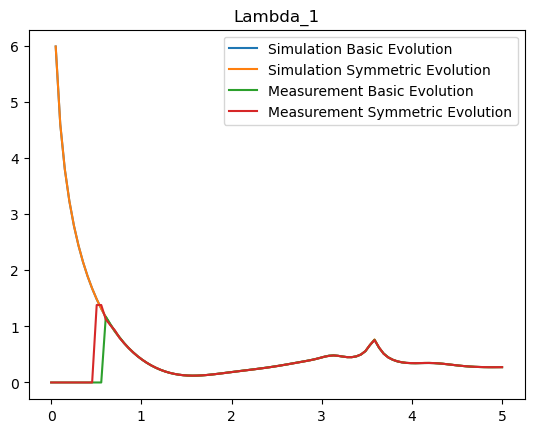

In [100]:
plt.plot(time, lambd_smooth[2,:,1], label = f'Simulation Basic Evolution')
plt.plot(time, lambd_smooth_sym[2,:,1], label = f'Simulation Symmetric Evolution')
plt.plot(time, lambd_ex9[:,1], label = f'Measurement Basic Evolution')
plt.plot(time, lambd_ex9_1[:,1], label = f'Measurement Symmetric Evolution')
plt.legend()
plt.title('Lambda_1')
plt.savefig('lambda1_ex1.png', dpi = 300)

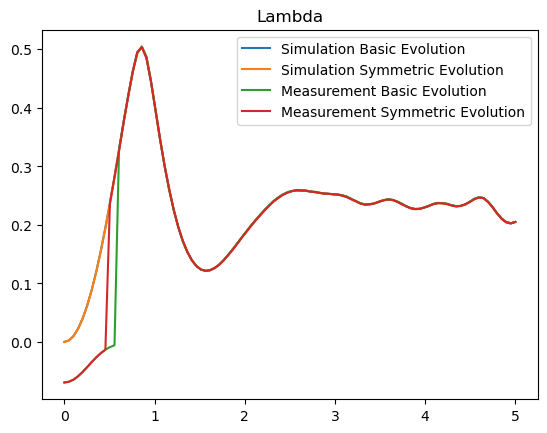

In [101]:
plt.plot(time, lambd_smooth[2,:,2], label = f'Simulation Basic Evolution')
plt.plot(time, lambd_smooth_sym[2,:,2], label = f'Simulation Symmetric Evolution')
plt.plot(time, lambd_ex9[:,2], label = f'Measurement Basic Evolution')
plt.plot(time, lambd_ex9_1[:,2], label = f'Measurement Symmetric Evolution')
plt.legend()
plt.title('Lambda')
plt.savefig('lambda_ex9.png', dpi = 300)

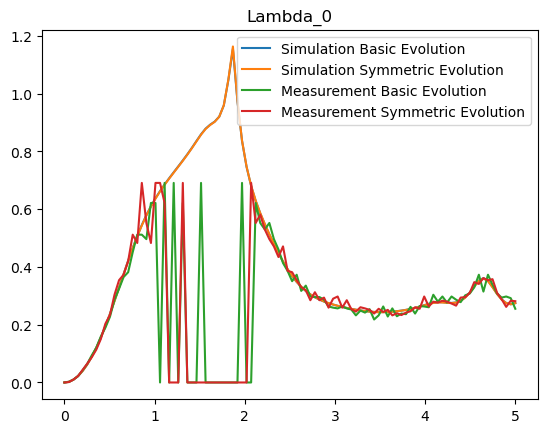

In [102]:
plt.plot(time, lambd_smooth[2,:,0], label = f'Simulation Basic Evolution')
plt.plot(time, lambd_smooth_sym[2,:,0], label = f'Simulation Symmetric Evolution')
plt.plot(time, lambd_ex9_20[:,0], label = f'Measurement Basic Evolution')
plt.plot(time, lambd_ex9_1_20[:,0], label = f'Measurement Symmetric Evolution')
plt.legend()
plt.title('Lambda_0')
plt.savefig('lambda0_ex9_20.png', dpi = 300)

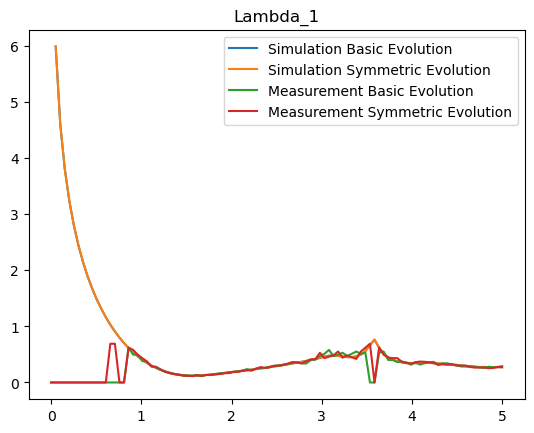

In [103]:
plt.plot(time, lambd_smooth[2,:,1], label = f'Simulation Basic Evolution')
plt.plot(time, lambd_smooth_sym[2,:,1], label = f'Simulation Symmetric Evolution')
plt.plot(time, lambd_ex9_20[:,1], label = f'Measurement Basic Evolution')
plt.plot(time, lambd_ex9_1_20[:,1], label = f'Measurement Symmetric Evolution')
plt.legend()
plt.title('Lambda_1')
plt.savefig('lambda1_ex9_20.png', dpi = 300)

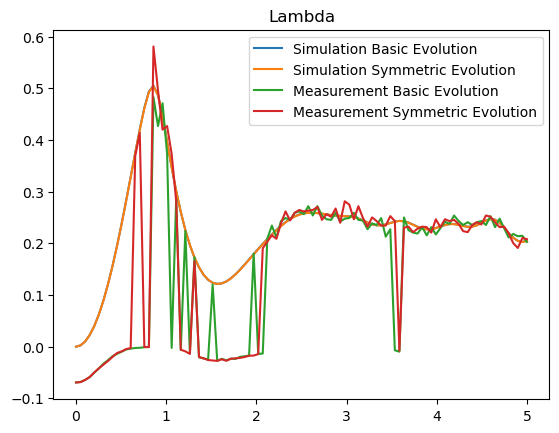

In [104]:
plt.plot(time, lambd_smooth[2,:,2], label = f'Simulation Basic Evolution')
plt.plot(time, lambd_smooth_sym[2,:,2], label = f'Simulation Symmetric Evolution')
plt.plot(time, lambd_ex9_20[:,2], label = f'Measurement Basic Evolution')
plt.plot(time, lambd_ex9_1_20[:,2], label = f'Measurement Symmetric Evolution')
plt.legend()
plt.title('Lambda')
plt.savefig('lambda_ex9_20.png', dpi = 300)

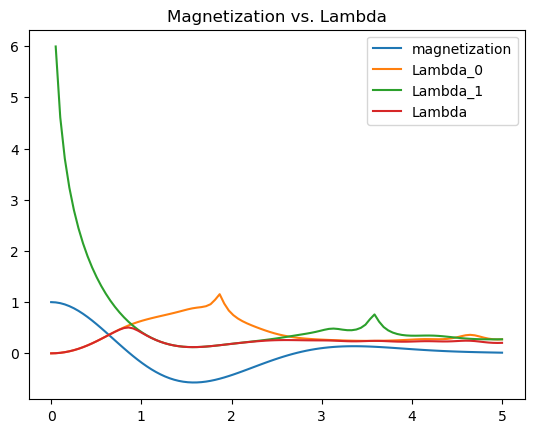

In [105]:
plt.plot(time, mt_smooth, label = f'magnetization')
plt.plot(time, lambd_smooth[2,:,0], label = f'Lambda_0')
plt.plot(time, lambd_smooth[2,:,1], label = f'Lambda_1')
plt.plot(time, lambd_smooth[2,:,2], label = f'Lambda')
plt.legend()
plt.title('Magnetization vs. Lambda')
plt.savefig('mag_lambd.png', dpi = 300)